In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from src.datalib import *
from scipy.ndimage import gaussian_filter
from scipy import ndimage
import skimage
import os
import pandas

from tqdm import tqdm
%matplotlib widget

In [3]:
wavelength_to_index = lambda x, wavelengths: np.argmin( np.abs( wavelengths - x ) )

def min_max(arr):
    return  abs( (arr - arr.min()) / (arr.max() - arr.min()) )#.astype(np.uint8)

# 1. Load LIBS Dataset

In [4]:
file_libs_metadata = r'E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsmetadata.txt'
file_libs_data = r"E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsdata"

libs_manipulator = MapData(file_path = file_libs_data)
libs_manipulator.load_wavelenths()
libs_manipulator.load_all_data('libs')
libs_manipulator.baseline_correct()

loading wavelengths
loading metadata
preprocessed file was not found; setting overwrite to True
loading raw data
getting baselines


In [5]:
libs_manipulator.get_map_dimensions()
nx, ny = libs_manipulator.map_dimensions
spectrum = libs_manipulator.spectra.reshape(ny, nx, -1)
wavelengths = libs_manipulator.wvl

# Correct flipped dimensions
spectrum[1::2, :] = spectrum[1::2, ::-1]

getting map dimensions


# 2. Load ICP-MS Data

['E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma//LA-ICP-MS//P36B//Export////P36 metadata.csv']
['E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma//LA-ICP-MS//P36B//Export////P36 metadata.csv']
['E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma//LA-ICP-MS//P36B//Export////P36 metadata.csv']


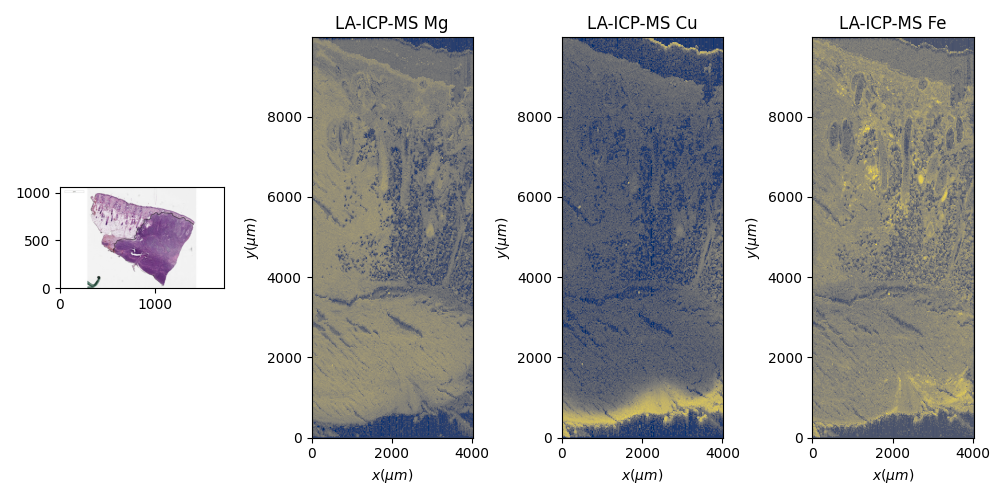

In [6]:
main_dir = r"E:/Data/Data_LIBS/Data_Brno/"
sample_dir = r"P36 - Epithelioid angiosarcoma//"
dir_ICP = main_dir + sample_dir + r"LA-ICP-MS//P36B//Export//"
dir_image = main_dir + sample_dir + r"Histology//"
dir_LIBS = main_dir + sample_dir + r'LIBS//'


def read_image(folder,index=0):
    files = [folder+'//'+f for f in os.listdir(folder) if f.endswith('jpg')]
    return skimage.io.imread(files[index])

def read_metadata(file1):
    df = pandas.read_csv(file1,encoding = "ISO-8859-1",header=None)
    map_dims = [float(df[1][0].split('x')[0]),float(df[1][0].split('x')[1])]
    spot_dims = [float(df[1][1].split('x')[0]),float(df[1][1].split('x')[1])]
    return map_dims, spot_dims

def read_icp(folder, name='Total'):
    file1 = [folder+'//'+f for f in os.listdir(folder) if f.endswith('csv') and 'metadata' in f]
    print(file1)
    map_dims, spot_dims = read_metadata(file1[0])
    files = [folder+'//'+f for f in os.listdir(folder) if f.endswith('csv') and name in f]
    df = pandas.read_csv(files[0],encoding = "ISO-8859-1",header=None)
    df = df.fillna(0)
    data = df.to_numpy()
    data-=data.min()+1
    return map_dims, spot_dims, data

names_ICP = ['Mg','Cu','Fe']
n_ICP = len(names_ICP)
data_ICP = []
for i in range(0, n_ICP):
    map_dims, spot_dims, data = read_icp(dir_ICP,name=names_ICP[i])
    data_ICP.append(data)

fig, ax = plt.subplots(1,1+n_ICP,figsize=[10,5])

sample_image = read_image(dir_image)
ax[0].imshow(sample_image,origin='lower')

for i in range(0, n_ICP):
    ax[i+1].imshow(data_ICP[i], norm = colors.LogNorm(vmin = 10, vmax=data.max()), cmap = 'cividis', extent=[0,map_dims[0],0,map_dims[1]])
    ax[i+1].set_xlabel(r'$x (\mu m)$')
    ax[i+1].set_ylabel(r'$y (\mu m)$')
    ax[i+1].set_title('LA-ICP-MS '+ str(names_ICP[i]))

fig.tight_layout()

# 3. Attemp Alignment

## 3.1 Get the two images we will align

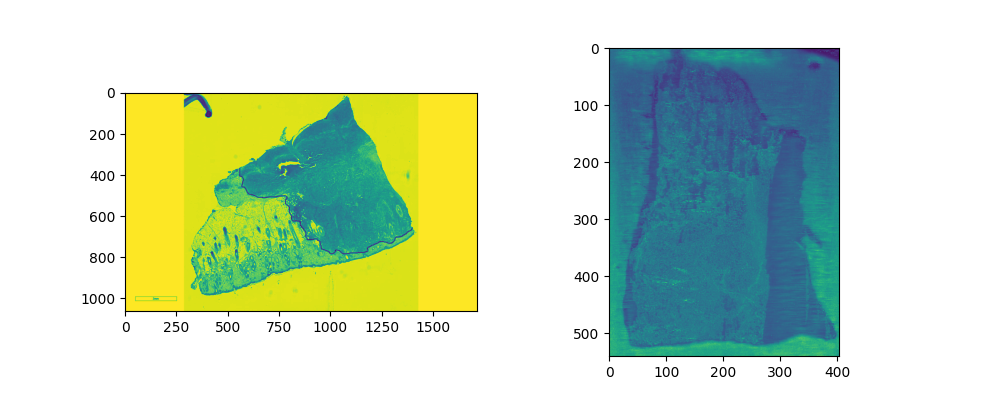

In [7]:
im_i = sample_image[:, :, 0]/255 # RGB
im_j = min_max(spectrum[:, :, wavelength_to_index(266.106, wavelengths)]) # LIBS

fig, axs = plt.subplots(1, 2, figsize = (10, 4))

ax = axs[0]
ax.imshow(im_i[:, :])

ax = axs[1]
ax.imshow(im_j)

## 3.2 Registration

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import gaussian_filter
from MI import MI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mi_check = []

mi_module = MI(dimension = 2, num_bins = 64, kernel_sigma = 1)

def apply_transform(image, scale, rotation, translation):
    device = image.device
    height, width = image.shape
    center = torch.tensor([width / 2, height / 2], device=device)
    
    # Transformation matrix with differentiable operations
    scale_matrix = torch.eye(3, device=device)
    scale_matrix[0, 0] = scale[0]
    scale_matrix[1, 1] = scale[1]
    
    rotation_matrix = torch.eye(3, device=device)
    rotation_matrix[0, 0] = torch.cos(rotation)
    rotation_matrix[0, 1] = -torch.sin(rotation)
    rotation_matrix[1, 0] = torch.sin(rotation)
    rotation_matrix[1, 1] = torch.cos(rotation)
    
    translation_matrix = torch.eye(3, device=device)
    translation_matrix[0, 2] = translation[0]
    translation_matrix[1, 2] = translation[1]

    # Combine the matrices
    transform_matrix = translation_matrix @ rotation_matrix @ scale_matrix
    
    # Note: affine_grid expects the 2x3 matrix, so we take the first two rows
    transform_matrix_2x3 = transform_matrix[:2, :]
    
    grid = F.affine_grid(transform_matrix_2x3.unsqueeze(0), image.unsqueeze(0).unsqueeze(0).shape, align_corners=False)
    transformed_image = F.grid_sample(image.unsqueeze(0).unsqueeze(0), grid, align_corners=False, mode='bilinear')
    
    # Check if the transformed image requires gradients
    if not transformed_image.requires_grad:
        print("transformed_img1 does not require gradients.")

    return transformed_image.squeeze()

def gaussian_pyramid(image, num_levels):
    pyramid = [image]
    for _ in range(num_levels - 1):
        image = gaussian_filter(image.cpu().numpy(), sigma=1)
        image = torch.from_numpy(image[::2, ::2]).float().to(device)
        pyramid.append(image)
    return pyramid[::-1]

def register_images(image1, image2, num_levels = 3, num_iterations = 2000, learning_rate = 0.05):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image1 = image1.float().to(device)
    image2 = image2.float().to(device)
    
    # # Normalize images to [0, 1] range
    # image1 = (image1 - image1.min()) / (image1.max() - image1.min())
    # image2 = (image2 - image2.min()) / (image2.max() - image2.min())
    
    # Create Gaussian pyramids
    pyramid1 = gaussian_pyramid(image1, num_levels)
    pyramid2 = gaussian_pyramid(image2, num_levels)
    
    # Initialize transformation parameters
    scale = torch.tensor([1.0, 1.0], requires_grad = True, device = device)
    rotation = torch.tensor(0.0, requires_grad = True, device = device)
    translation = torch.tensor([0.0, 0.0], requires_grad = True, device = device)
    
    for level in range(num_levels):
        img1 = pyramid1[level]
        img2 = pyramid2[level]
        
        optimizer = torch.optim.Adam([scale, rotation, translation], lr=learning_rate)
        
        for h in range(num_iterations):
            print(f"Iteration {h}/{num_iterations}", end = '\r')
            optimizer.zero_grad()
            
            transformed_img1 = apply_transform(img1, scale, rotation, translation)
            transformed_img1 = F.interpolate(transformed_img1.unsqueeze(0).unsqueeze(0), 
                                             size=img2.shape, mode='bilinear', align_corners=False).squeeze()
            
            # Calculate mutual information using the MI module
            mi = mi_module.mi(transformed_img1.unsqueeze(0).unsqueeze(0), img2.unsqueeze(0).unsqueeze(0))
            mi_check.append(mi)
            
            loss = -mi  # We want to maximize MI, so we minimize negative MI
            loss.backward()
            optimizer.step()
        
        # Update learning rate for next level
        # learning_rate *= 0.5
    
    # Apply final transformation to original image
    final_transformed_img1 = apply_transform(image1, scale, rotation, translation)
    final_transformed_img1 = F.interpolate(final_transformed_img1.unsqueeze(0).unsqueeze(0), 
                                           size=image2.shape, mode='bilinear', align_corners=False).squeeze()
    
    return final_transformed_img1, scale.detach(), rotation.detach(), translation.detach()

aligned_image, scale, rotation, translation = register_images(torch.tensor(im_i), torch.tensor(im_j))

print(f"Scale: {scale}")
print(f"Rotation: {rotation}")
print(f"Translation: {translation}")

Scale: tensor([0.2870, 1.3738], device='cuda:0')
Rotation: -0.39534860849380493
Translation: tensor([ 0.2215, -0.6250], device='cuda:0')


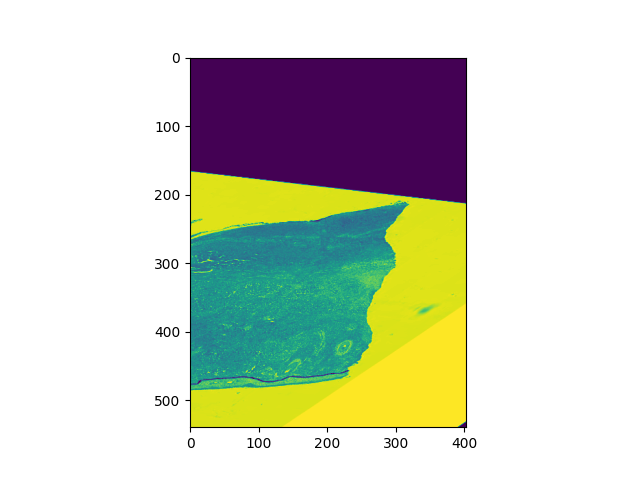

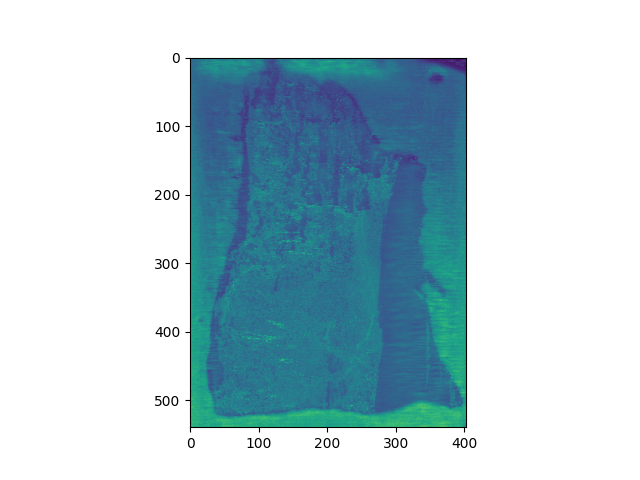

In [9]:
plt.figure()
plt.imshow(aligned_image.cpu().detach().numpy())

plt.figure()
plt.imshow(im_j)

In [65]:
mi_check[-1]

tensor(0.1731, device='cuda:0', grad_fn=<MeanBackward0>)